In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# Customize matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

import seaborn as sns
import glob
from collections import defaultdict

from qupath_processing.utilities import get_image_to_exlude_list
from shapely import Polygon

In [128]:
from PIL import ImageColor


def get_color(distiguish=True, return_type='dict', return_unit='hex'):
    
    if distiguish:
        layers_color = {"Layer 1": "#ff0000"
                , "Layer 2":"#ff0099"
                , "Layer 3":"#cc00ff"
                , "Layer 4":"#3300ff"
                , "Layer 5":"#0066FF"
                , "Layer 6 a":"#00ffff"
                , "Layer 6 b":"#00ff66"
               }
    else:
        layers_color = {"Layer 1": "#ff0000"
                , "Layer 2/3":"#751402"
                , "Layer 4":"#3300ff"
                , "Layer 5":"#0066FF"
                , "Layer 6 a":"#00ffff"
                , "Layer 6 b":"#00ff66"
               }
    layers_color_int = {}
    layers_color_float = {}
    
    for key, value in layers_color.items():
        layers_color_int[key] = list(np.array(ImageColor.getcolor(value, "RGB")))
        layers_color_float[key] = list(np.array(ImageColor.getcolor(value, "RGB")) / 255)
        
    if return_type == 'dict':
        if return_unit == 'hex':
            return layers_color
        elif return_unit == 'float':
            return layers_color_float
        elif return_unit == 'int':
            return layers_color_int
    
    if return_type == 'list':
        if return_unit == 'hex':
            return list(layers_color.values())
        elif return_unit == 'float':
            return list(layers_color_float.values())
        elif return_unit == 'int':
            return list(layers_color_int.values())
    
    raise(ValueError('return_type or return_unit not valid'))

In [70]:
def get_per_layer_df(path):
    file_list_layer = glob.glob(path + '*.csv')
    layer_df = pd.DataFrame()
    dfs = [layer_df]
    for file in file_list_layer:
        df = pd.read_csv(file, index_col=0)
        dfs.append(df)
    layer_df = pd.concat(dfs)
    return layer_df

In [71]:
def get_image_to_exclude(density_per_percentage_dataframe, nb_sigma = 1,
                         output_path = None, visualisation_flag=False ):
    image_to_exclude = []
    density_mean = density_per_percentage_dataframe.groupby('depth_percentage').densities.mean().to_numpy()
    density_std = density_per_percentage_dataframe.groupby('depth_percentage').densities.std().to_numpy()
    for image in np.unique(density_per_percentage_dataframe.image):
        if (density_per_percentage_dataframe[density_per_percentage_dataframe.image == image].densities.to_numpy() >
            density_mean + nb_sigma * density_std).any() or \
           (density_per_percentage_dataframe[density_per_percentage_dataframe.image == image].densities.to_numpy() < 
            density_mean - nb_sigma * density_std).any():
            image_to_exclude.append(image)

    if visualisation_flag or output_path:
        depth_percentage_values = np.unique(density_df.depth_percentage)
        
        nb_col = 4
        nb_row = int(len(depth_percentage_values) / nb_col)
        
        fig,ax = plt.subplots(nb_row, nb_col, figsize=(10,10))
                              
        for index, density in enumerate(depth_percentage_values):
            col = int(index / nb_col)
            row = index % nb_col
            
            densities = density_df[density_df.depth_percentage==density].densities.to_numpy()
            density_mean = densities.mean()
            density_std = densities.std()
            ax[col][row].hist(densities, bins=20, color='black')
            x_minus_3_sigma = density_mean-3*density_std
            x_plus_3_sigma =  density_mean+3*density_std
            ax[col][row].set_xlabel("Cell density cells/mm3")
            ax[col][row].axvline(x = x_minus_3_sigma, color='black')
            ax[col][row].axvline(x = x_plus_3_sigma, color='black')
            ax[col][row].set_title(f' {density*100:.2f}%')
            ax[col][row].set_ylim(0, 45)
            
        fig.tight_layout()
        if output_path is not None:
             plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    return image_to_exclude

In [72]:
def concate_density_dataframes(file_list, std_dev_factor = 1):
    """
    conctact dataframe locatated in a directory and filter the density value with std_dev_factor
    """
    df = pd.DataFrame()
    densities = []
    
    
    for file in file_list:
        df_image = pd.read_csv(file, index_col=0)
        densities.append(df_image.densities)
    densities_mean = np.mean(densities)
    std_dev = np.std(densities) * 1
    df = pd.DataFrame()
    frames = []
    for file in file_list:
        df_image = pd.read_csv(file, index_col=0)
        if np.mean(df_image.densities) < std_dev:
            print(np.unique(df_image.image))
        else:
            frames.append(df_image)
    
    return pd.concat(frames, ignore_index=True)

In [73]:
def get_filtered_density_df(images_id, density_df,):
    image_id = list(density_df['image'])
    mask = density_df.image.isin(images_id)
    return density_df[mask]

In [74]:


def plot(densities_per_depth, title,  plot_median=False, plt_detail=False,
         display_legend=False, output_path=None):
    """
    :param densities: np.array of np.float.32 of shape (nb_images, nb_percentages, 2) 2-> depth_percentage, density
    """

            
    average={}
    median={}
    plt.figure(figsize=(5,5))
    
    density_dict=defaultdict(list)
    for density in densities_per_depth:
        densities_value = density[:,1]
        depthes = density[:,0]
        if plt_detail:
            plt.plot(densities_value, depthes)
        for density, depth in zip(densities_value, depthes):
            density_dict[depth].append(density)

    for depth, densities in density_dict.items():  
        average[depth] = np.average(densities)      
        median[depth] = np.median(densities)   

    
    plt.plot(list(average.values()), list(average.keys()), linewidth=3, c='black', label='average values')
    if plot_median:
        plt.plot(list(median.values()), list(median.keys()), linewidth=3, c='khaki', label='median values')
    plt.title(f'{title}')
    plt.gca().set_xlabel("Cell density cells/mm3")
    plt.gca().set_ylabel("percentage of depth [%]")
    current_values = plt.gca().get_yticks()
    _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
    current_values = plt.gca().get_xticks()
    _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
    plt.legend()
    plt.gca().invert_yaxis()

    
    if display_legend:
        lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
        for i in range(1):
            lgnd.legendHandles[i]._sizes = [5]
            lgnd.legendHandles[i]._alpha = 1 
            
    if output_path is not None:
         plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
   

In [75]:
def plot_mean_and_std_dev(density_dfs, labels='' , colors='blue', 
                          title=None, output_path=None):

    '''
    param: density_df' list of (or a single) pandas dataframe with columns : image 	depth_percentage densities
    '''

    if not isinstance(density_dfs, list):
        density_dfs = [density_dfs]

    if not isinstance(labels, list):
        labels = [labels]    

    if not isinstance(colors, list):
        colors = [colors]    


    
    plt.figure(figsize=(5,5))
    for density_df, label, color in zip(density_dfs, labels, colors):
        percentage = np.unique(density_df.depth_percentage)
        densities = np.array(list(density_df.groupby('depth_percentage')['densities'].apply(list).values))
        
        density_std = np.std(densities, axis=1)
        density_mean = densities.mean(axis=1)
        
        
        _=plt.plot (density_mean, percentage, label=label + ' Mean densities', linewidth=4, c=color)
        _=plt.fill_betweenx(percentage,density_mean-density_std,density_mean+density_std,alpha=.3, color=color,
                            label= label + ' Standard deviation')
        plt.legend()
        
        plt.gca().set_xlabel("Cell density [cells/mm$^3$]")
        plt.gca().set_ylabel("Standard cortical depth [%]]")
        current_values = plt.gca().get_xticks()
        _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
        current_values = plt.gca().get_yticks()
        _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])

    plt.gca().invert_yaxis()
    if title: plt.title(title)
        
    if output_path is not None:
         plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    

In [76]:
def dataframe_to_array(dataframe):
    # compute the average cell density
    densities = []
    for image in np.unique(dataframe.image):
        image_data = dataframe[dataframe['image']==image].to_numpy()[:,[1,2]]
        densities.append(image_data)
    return  np.array(densities, dtype=np.float32)
    

In [156]:
def plot_density_per_layer(_layer_df, output_path=None, title='Cell density per layer', distiguish=True):
    densities = _layer_df.to_numpy()
    mean = densities.mean(axis=0)
    std = densities.std(axis=0)
    columns = list(_layer_df.columns)
    N = densities.shape[1]
    ind = np.arange(N)    # the x locations for the groups
    width = 0.7       # the width of the bars: can also be len(x) sequence

    bar_colors = get_color(distiguish=distiguish, return_type='list', return_unit='float')
    plt.figure(figsize=(5, 5))
    p1 = plt.bar(ind, mean, width,  yerr=std, color=bar_colors)
    #plt.errorbar(ind, mean, color="b")
    plt.ylabel('Cell density (cells/mm3)')
    plt.title(title)
    plt.xticks(ind, columns)   
    current_values = plt.gca().get_yticks()
    _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
    #plt.yticks(np.arange(0, 81, 10))
    #plt.legend((p1[0],('Men')))
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [10]:
per_percentage_path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/02022024/Per_percentage/'
file_list = glob.glob(per_percentage_path + '*.csv')
density_df = concate_density_dataframes(file_list)


image_to_exlude_path = ('/gpfs/bbp.cscs.ch/data/project/proj53/LayerBoundariesProject/Analysis/Exclude-ID_v20240206jm.xlsx')
df_image_to_exclude = pd.read_excel(image_to_exlude_path, index_col=0, skiprows=[0,1,2,3,4,5,6,7])
db_image_to_exlude_list = get_image_to_exlude_list(df_image_to_exclude)

# Exclude image for Excel file
db_indice = density_df[(density_df['image'].isin(db_image_to_exlude_list))].index
density_df = density_df.drop(db_indice)

'''
# Exclude image with density outsite N sigma of std
sigma_image_to_exclude = get_image_to_exclude(density_df, nb_sigma=2,
                                              output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/sigma_rejection.svg
                                              ')
print(f' {len(sigma_image_to_exclude)} images exclude / {len(np.unique(density_df.image))} ')


sigma_indice = density_df[(density_df['image'].isin(sigma_image_to_exclude))].index
density_df = density_df.drop(sigma_indice)
'''


"\n# Exclude image with density outsite N sigma of std\nsigma_image_to_exclude = get_image_to_exclude(density_df, nb_sigma=2,\n                                              output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/sigma_rejection.svg\n                                              ')\nprint(f' {len(sigma_image_to_exclude)} images exclude / {len(np.unique(density_df.image))} ')\n\n\nsigma_indice = density_df[(density_df['image'].isin(sigma_image_to_exclude))].index\ndensity_df = density_df.drop(sigma_indice)\n"

/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


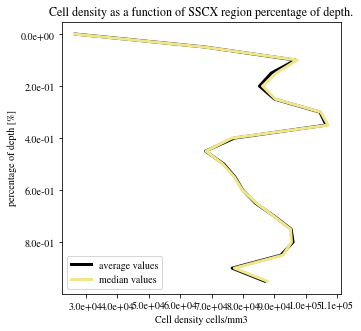

In [11]:
data = dataframe_to_array(density_df)
plot(data, 'Cell density as a function of SSCX region percentage of depth.',
    plot_median=True, plt_detail=False, output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/median_density_percentage.svg')

/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


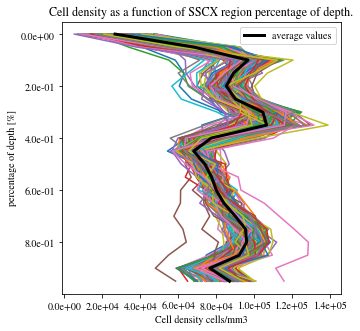

In [12]:
plot(data, 'Cell density as a function of SSCX region percentage of depth.',
     plt_detail=True, output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/full_density_percentage.svg')

/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


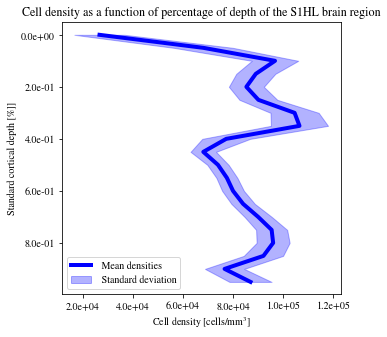

In [13]:
plot_mean_and_std_dev(density_df, 
                      title="Cell density as a function of percentage of depth of the S1HL brain region",
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/full_std_density_percentage.svg')

In [14]:
meta_df = pd.read_csv('/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/20231102/datasets/Exported_Features/Dataframes/metadata.csv', index_col=0)

In [15]:
ls -l /gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/20231102/datasets/Exported_Features/Dataframes/metadata.csv

-rw-r-----+ 1 jacquemi bbp 619625 Jan 30 16:24 /gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/20231102/datasets/Exported_Features/Dataframes/metadata.csv


In [16]:
analyse_df = meta_df[meta_df.Analyze == True]
left_meta_df = analyse_df[analyse_df['hemisphere(L/R)']=='left']
right_meta_df = analyse_df[analyse_df['hemisphere(L/R)']=='right']

In [17]:
left_image_id = list(left_meta_df['Image_Name'])
right_image_id = list(right_meta_df['Image_Name'])
left_density_df = get_filtered_density_df(left_image_id, density_df)
right_density_df = get_filtered_density_df(right_image_id, density_df)

/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


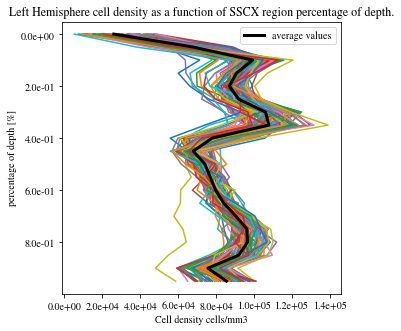

In [18]:
data = dataframe_to_array(left_density_df)
plot(data, 'Left Hemisphere cell density as a function of SSCX region percentage of depth.',
     plt_detail=True,
   output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/left_density_percentage.svg')

/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


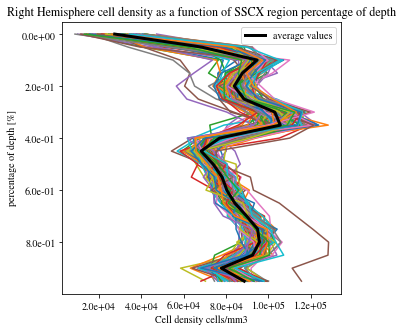

In [19]:
data = dataframe_to_array(right_density_df)
plot(data, 'Right Hemisphere cell density as a function of SSCX region percentage of depth',
     plt_detail=True,
    output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities//right_std_density_percentage.svg')

/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


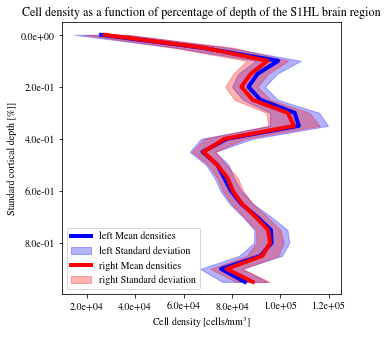

In [20]:
plot_mean_and_std_dev([left_density_df,right_density_df], 
                      labels=['left', 'right'],
                      colors=['blue', 'red'],
                      title="Cell density as a function of percentage of depth of the S1HL brain region",
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities//left_right_std_density_percentage.svg')


In [21]:
project_ID_list = np.unique(analyse_df['Project_ID'])

/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1

/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/2808587699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/nvme/jacquemi/2091495/ipykernel_91015/1117596345.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_xticklabels(['{:.1

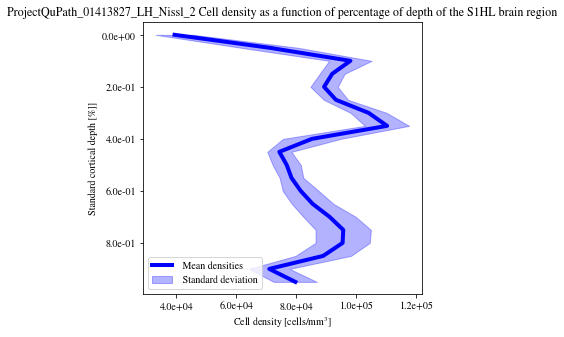

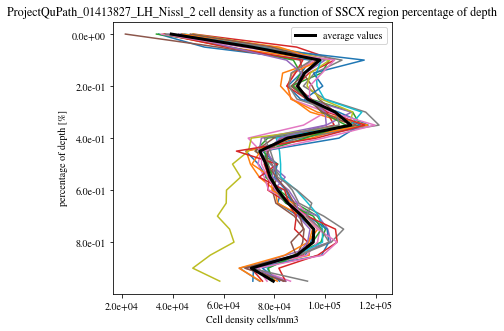

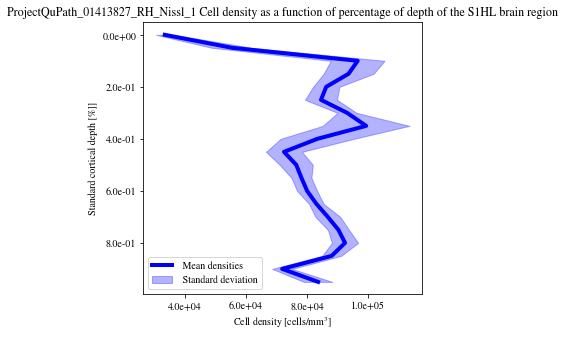

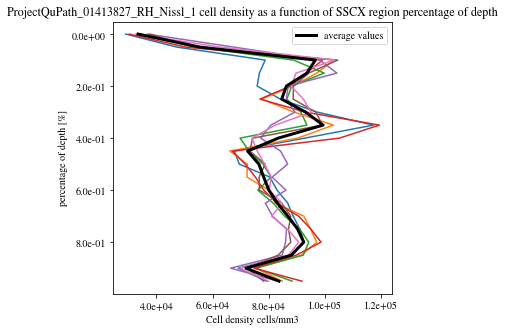

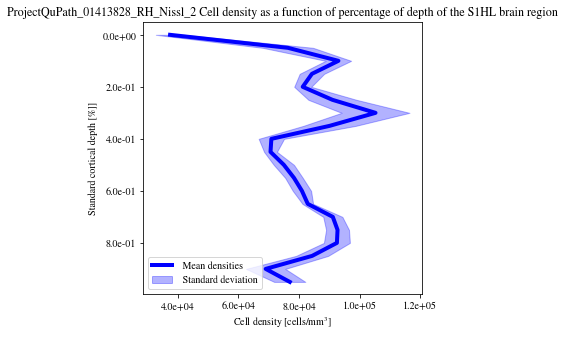

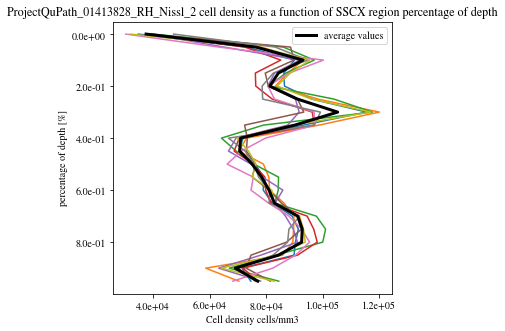

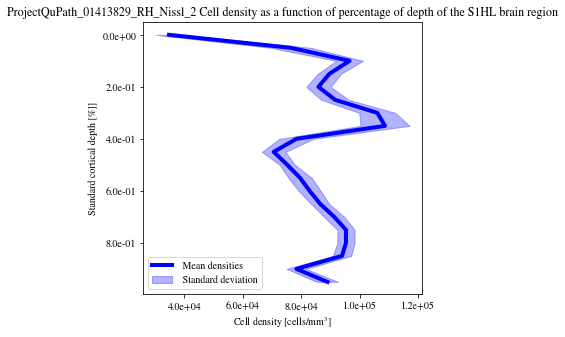

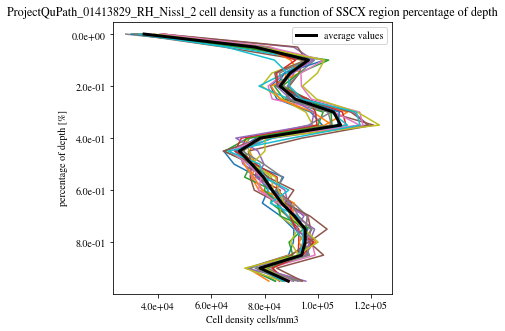

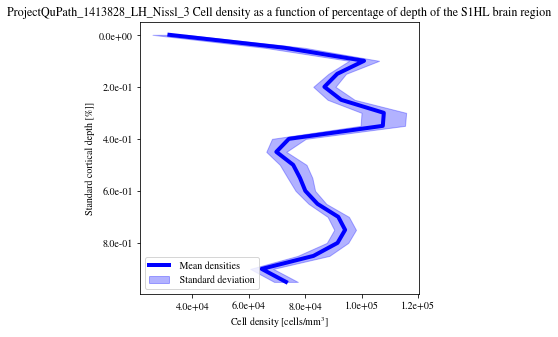

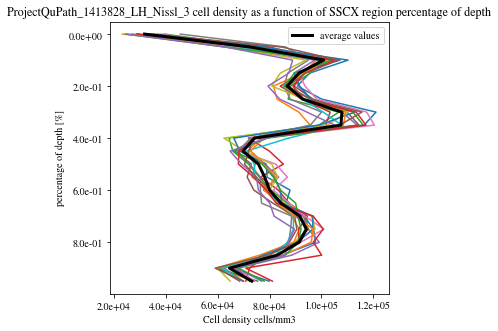

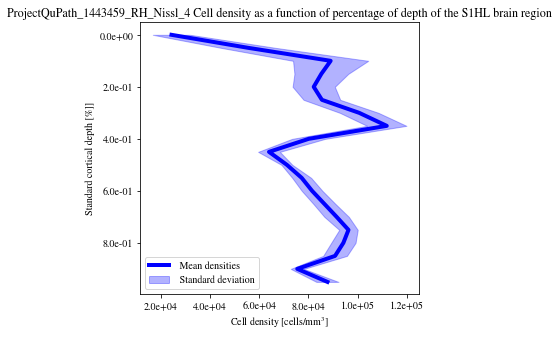

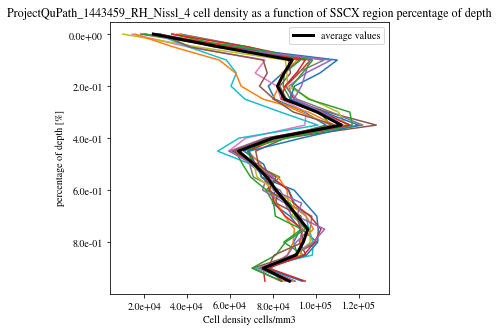

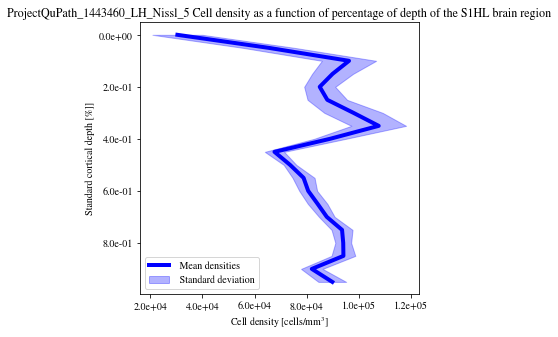

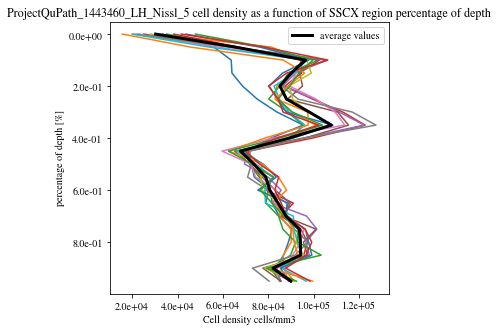

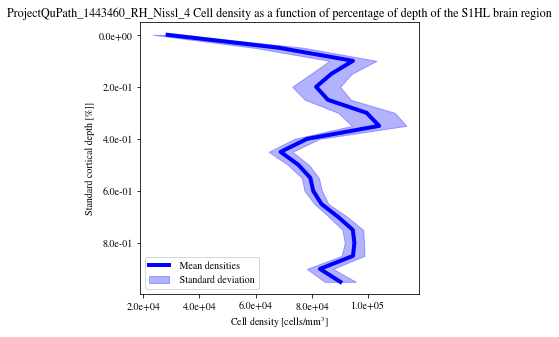

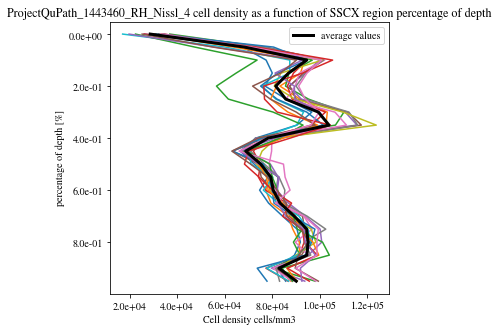

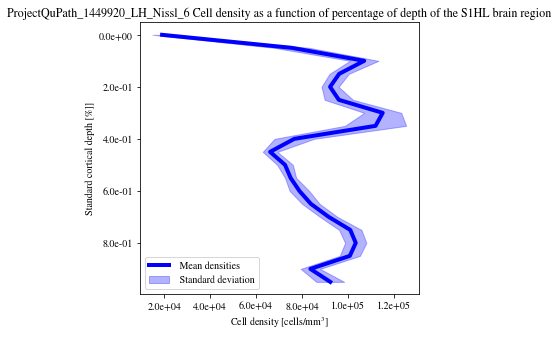

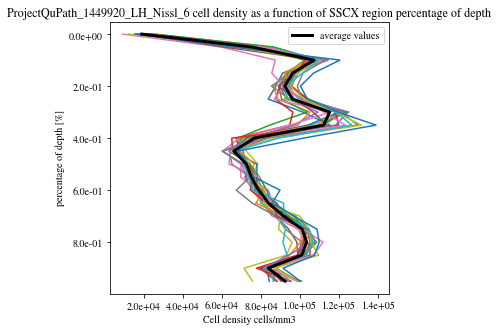

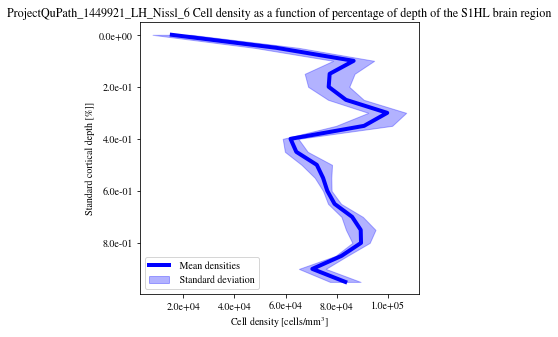

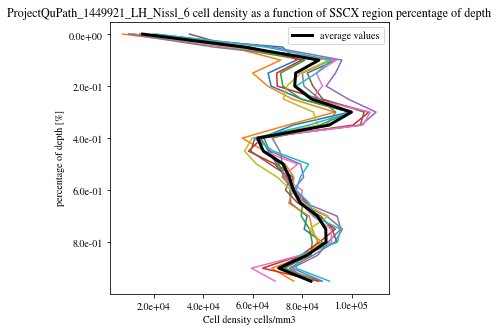

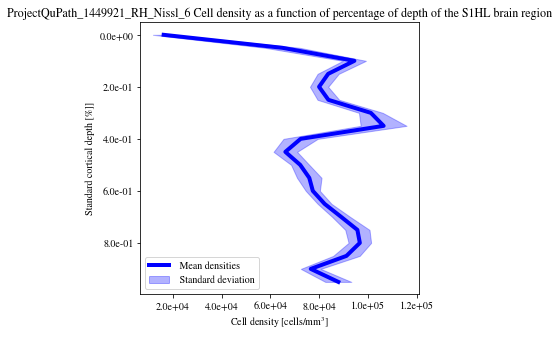

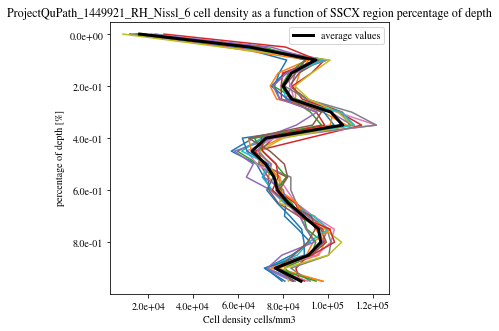

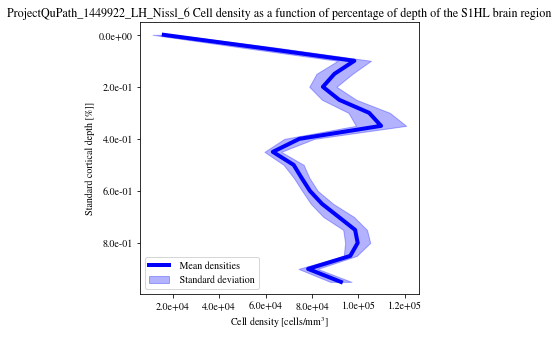

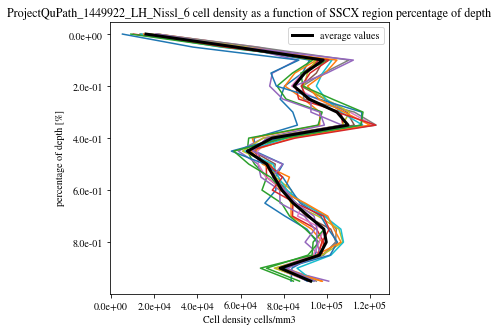

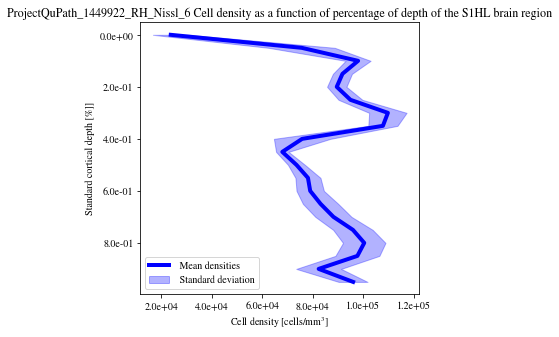

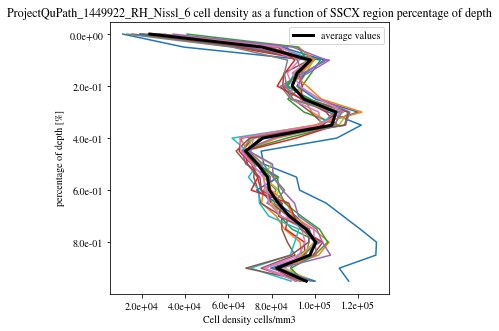

In [22]:
for project_id in project_ID_list:
    animal_meta_df = analyse_df[analyse_df['Project_ID']==project_id]
    animal_image_id = list(animal_meta_df['Image_Name'])
    animal_density_df = get_filtered_density_df(animal_image_id, density_df)
    data = dataframe_to_array(animal_density_df)
    plot_mean_and_std_dev([animal_density_df], 
                      title=f"{project_id} Cell density as a function of percentage of depth of the S1HL brain region")
    plot(data, f'{project_id} cell density as a function of SSCX region percentage of depth', plt_detail=True,
        output_path=f'/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/{project_id}_std_density_percentage.svg')

# Cell density mean value per image cells/mm3

In [68]:
nb_images = len(density_df[density_df.depth_percentage == 0.00])
print(f'mean density on {nb_images} images => {density_df.densities.mean():.2f} cells/mm3')

mean density on 199 images => 83200.79 cells/mm3


# Density per layers

In [157]:
path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/03212024/Merged_second_layer_prediction/'
layer_df = get_per_layer_df(path)

/nvme/jacquemi/2091495/ipykernel_91015/1820575466.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


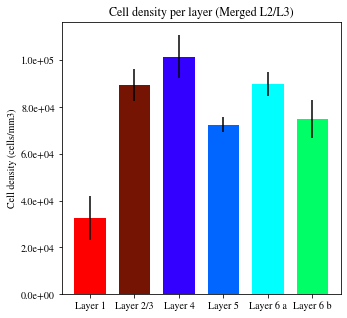

In [159]:
plot_density_per_layer(layer_df,
                       title='Cell density per layer (Merged L2/L3)',
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/per_layer_merge_23.svg',
                      distiguish=False)

In [160]:
path_d = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/03212024/Distinguishable_second_layer_prediction/'
d_layer_df = get_per_layer_df(path_d)

/nvme/jacquemi/2091495/ipykernel_91015/1820575466.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


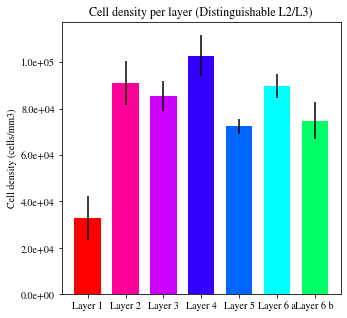

In [162]:
plot_density_per_layer(d_layer_df,
                     title='Cell density per layer (Distinguishable L2/L3)',
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/per_layer_distinguish_23.svg')

In [161]:
d_layer_df.mean(axis=0)

Layer 1       32625.797535
Layer 2       90947.667065
Layer 3       85353.240229
Layer 4      102815.985402
Layer 5       72379.917123
Layer 6 a     89678.776630
Layer 6 b     74801.879096
dtype: float64

In [158]:
layer_df.mean(axis=0)

Layer 1       32484.024021
Layer 2/3     89614.989017
Layer 4      101631.524256
Layer 5       72385.093621
Layer 6 a     89819.209309
Layer 6 b     74808.447628
dtype: float64

# Layers boundaries as a fonction of the distance to pia

In [163]:
path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Dataframes/Distinguishable_second_layer_prediction/03212024/'
filelist = glob.glob(path + '*.csv')

In [164]:
cleaned_filelist = filelist.copy()
for file in filelist:
    for image_to_remove in db_image_to_exlude_list:
        if file.find(image_to_remove) > -1:
            try:
                cleaned_filelist.remove(file)
            except ValueError:
                print(file)
            continue
            

/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Dataframes/Distinguishable_second_layer_prediction/03212024/Features_SLD_0000682.vsi-20x_02.csv
/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Dataframes/Distinguishable_second_layer_prediction/03212024/Features_SLD_0000681.vsi-20x_06.csv


In [165]:
filelist = cleaned_filelist
len(filelist)

199

In [166]:
df = pd.read_csv(filelist[0])
layers = np.unique(df.RF_prediction)
print(layers)

layer_distance_to_pia_min = defaultdict(list)
layer_distance_to_pia_max = defaultdict(list)
for file in filelist:
    df = pd.read_csv(file)
    layers = np.unique(df.RF_prediction)
    for layer in layers:
        layer_distance_filter = df[df['RF_prediction'] == layer]['Distance to annotation with Outside Pia µm'].to_numpy()
        # We compute the mean of the 5 min value
        sorted_value_indice = np.argsort(layer_distance_filter)
        min_value = layer_distance_filter[sorted_value_indice[:5]].mean()
        max_value = layer_distance_filter[sorted_value_indice[-5:]].mean()
       
        layer_distance_to_pia_min[layer].append(min_value)
        layer_distance_to_pia_max[layer].append(max_value)

nb_entry_per_layer = len(filelist)

distances = np.zeros((layers.size, nb_entry_per_layer), dtype=float)
for index, dis in enumerate(layer_distance_to_pia_min.values()):
    distances[index][:] = dis

mean = distances.mean(axis=1)
std = distances.std(axis=1)

ind = np.arange(layers.size)    # the x locations for the groups
width = 0.7       # the width of the bars: can also be len(x) sequence

['Layer 1' 'Layer 2' 'Layer 3' 'Layer 4' 'Layer 5' 'Layer 6 a' 'Layer 6 b']


/nvme/jacquemi/2091495/ipykernel_91015/4222916527.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


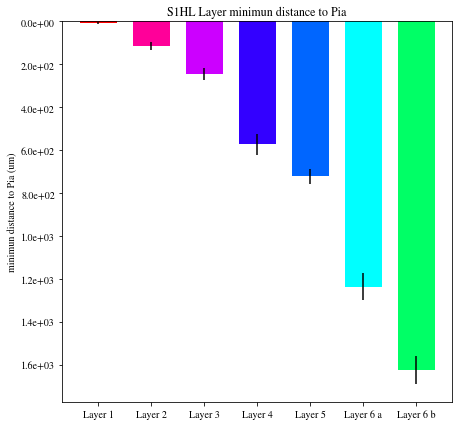

In [170]:
plt.figure(figsize=(7, 7))
color_bar =get_color(distiguish=True, return_type='list', return_unit='float')
p1 = plt.bar(ind, mean, width, yerr=std, color=color_bar)
plt.gca().invert_yaxis()

plt.ylabel('minimun distance to Pia (um)')
plt.title('S1HL Layer minimun distance to Pia')
 
plt.xticks(ind, layers)   
current_values = plt.gca().get_yticks()
_=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])

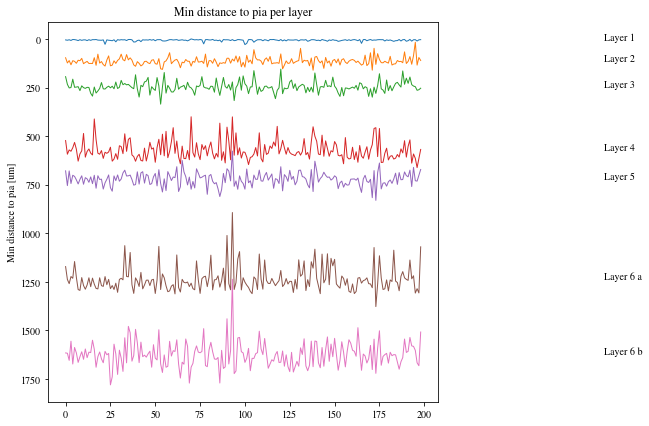

In [171]:
plt.figure(figsize=(7,7))
for layer in layers:
    distances = np.array(layer_distance_to_pia_min[layer])
    _=plt.plot (distances, linewidth=1)
    plt.text(300, distances.mean(), layer)
    plt.ylabel('Min distance to pia [um]')
    plt.title('Min distance to pia per layer')
    plt.gca().invert_yaxis()

In [172]:
from matplotlib.transforms import Bbox
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles.
    """
    
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.\n",
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

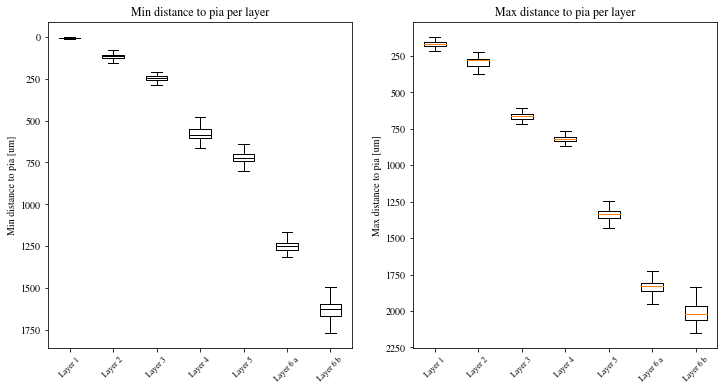

In [173]:
layers_distances_min = []
layers_distances_max = []

#plt.figure(figsize=(1,12))
for layer in layers:
    distances_min = np.array(layer_distance_to_pia_min[layer])
    layers_distances_min.append(distances_min)
    distances_max = np.array(layer_distance_to_pia_max[layer])
    layers_distances_max.append(distances_max)    

fig, ax = plt.subplots(1,2, figsize=(12, 6))
box = ax[0].boxplot(layers_distances_min, 0, '', 'black', patch_artist=False)
# change the color of its elements
for _, line_list in box.items():
    for line in line_list:
        line.set_color('black')
ax[0].set_xticklabels(layers,
                    rotation=45, fontsize=8)
ax[0].set_ylabel('Min distance to pia [um]')
ax[0].set_title('Min distance to pia per layer')
#ax[0].legend()
ax[0].invert_yaxis()


ax[1].boxplot(layers_distances_max, 0, '')
ax[1].set_xticklabels(layers,
                    rotation=45, fontsize=8)
ax[1].set_ylabel('Max distance to pia [um]')
ax[1].set_title('Max distance to pia per layer')
#ax[1].legend()
ax[1].invert_yaxis()

extent = extent = full_extent(ax[0]).transformed(fig.dpi_scale_trans.inverted())
output_path =  '/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities/minimum_distance_to_pia.svg'
fig.savefig(output_path, bbox_inches=extent)